In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import time
import random
import pickle
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
from torch import nn
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from scipy.io import loadmat
from revisitop.python.evaluate import compute_map, compute_ap

from torchvision.models import resnet50, ResNet50_Weights

## Carga de modelo 

In [68]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [69]:
class GeM_ResNet(nn.Module):    
    def __init__(self, features, pool):
        super(GeM_ResNet, self).__init__()
        self.features = nn.Sequential(*features)
        self.pool = pool
        self.fc = nn.Linear(2048,70)
    
    def forward(self, x):
        o = self.features(x)
        o = self.pool(o).squeeze(-1).squeeze(-1)
        o = self.fc(o)
        return o

In [70]:
weights = ResNet50_Weights.DEFAULT
model_resnet50 = resnet50(weights=weights)

features = list(model_resnet50.children())[:-2]
pool = GeM()

model_gem = GeM_ResNet(features, pool)
model_gem

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gem.to(device)

GeM_ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

## Creacion datasets de torch

In [71]:
class TestDataset(Dataset):
    def __init__(self, root_dir,data,query,transform=None):
        self.root_dir = root_dir
        self.query= query
        self.transform = transform
        self.data =data
        
        self.file_list = data['qimlist'] if query else data['imlist']
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f'{self.file_list[idx]}.jpg')
        image = Image.open(img_name)
        
        if self.query:
            crop_limits = self.data["gnd"][idx]["bbx"]
            image = image.crop(crop_limits)

        if self.transform != None:
            image = self.transform(image)

        return image

In [163]:
class RetrievalDataset(Dataset):
    def __init__(self, data, dataset_name,device, seed=48, transform=None, train=True):

        self.dataset_name = dataset_name
        self.transform = transform
        self.data = data
        self.device =device
        
        self.total_pos = []
        self.labels = []
        for i in range(len(self.data["gnd"])):
            total_pos_query = self.data["gnd"][i]["easy"] + self.data["gnd"][i]["hard"]
            labels_query = [i] * len(total_pos_query)
            self.total_pos += total_pos_query
            self.labels += labels_query

        # Split Entrenamiento/Validacion
        X_train, X_val, y_train, y_val = train_test_split(self.total_pos, self.labels, test_size=0.5,stratify=self.labels, random_state=seed)
        
        if train:
            self.pos = X_train
            self.label = y_train
        else:
            self.pos = X_val
            self.label = y_val

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        
        img = Image.open(f"revisitop/data/datasets/{self.dataset_name}/jpg/{self.data['imlist'][self.pos[idx]]}.jpg")
        label = self.label[idx]
            
        if self.transform:
            img = self.transform(img)

        return img.to(self.device), torch.tensor(label).to(self.device)

In [193]:
transform_train_aug = transforms.Compose([
                                          transforms.ColorJitter(0.4, 0.4, 0.4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.Resize((232,232)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                        ])

transform_val =  transforms.Compose([
                                          transforms.Resize((232,232)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                        ])


file_rox = "revisitop/data/datasets/roxford5k/gnd_roxford5k.pkl"
with open(file_rox, "rb") as f1:
    data_roxford5k = pickle.load(f1)

file_par = "revisitop/data/datasets/rparis6k/gnd_rparis6k.pkl"
with open(file_par, "rb") as f2:
    data_rparis6k = pickle.load(f2)

preprocess = weights.transforms()

oxford_dataset_train = RetrievalDataset(data_roxford5k, dataset_name="roxford5k", device=device,transform=transform_train_aug, train=True)
oxford_dataset_val = RetrievalDataset(data_roxford5k, dataset_name="roxford5k", device=device,transform=transform_val, train=False)

paris_dataset_train = RetrievalDataset(data_rparis6k, dataset_name="rparis6k",device=device, transform=transform_train_aug, train=True)
paris_dataset_val = RetrievalDataset(data_rparis6k, dataset_name="rparis6k",device=device, transform=transform_val, train=False)

## Funciones de entrenamiento y otras

In [150]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance, save_best = False):
        self.save_best = save_best
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss, dict, epoch, path="best_model.pt"):
        self.epochs_with_no_improvement += 1

        if val_loss in [np.nan]:
            return True

        if val_loss <= self.best_loss:
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0


            if self.save_best:
                torch.save({
                'epoch': epoch+1,
                'model_state_dict': dict,
                'loss': val_loss,
                }, path)

        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [151]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    max_epochs,
    batch_size,
    lr,
    optimizador,
    criterion,
    early_stopping_tolerance=10,
    save_best_model = True,
    device = device
):

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance, save_best= save_best_model)

    #Curvas de aprendizaje
    curves = {
            "train_loss": [],
            "val_loss": [],
        }

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Optimizador
    optimizer = optimizador

    # Early stopping
    n_epochs_with_no_improvement = 0
    stop = False

    t0 = time.perf_counter()

    for epoch in range(max_epochs):
        cumulative_train_loss = 0
        cumulative_val_loss = 0

        model.train()

        for i, (imgs, labels) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{max_epochs} - Batch {i+1}/{len(train_loader)}", end="")

            optimizer.zero_grad()

            # Predicción
            predictions = model(imgs)

            # Loss
            loss = criterion(predictions, labels)

            # Actualización de parámetros
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

        train_loss = cumulative_train_loss / len(train_loader)

        # Evaluación del modelo
        model.eval()
        with torch.no_grad():
            for i, (imgs,labels) in enumerate(val_loader):

                # Predicción
                predictions = model(imgs)

                # Loss
                val_loss = criterion(predictions, labels)
                
                cumulative_val_loss += val_loss.item()
            
            val_loss = cumulative_val_loss / len(val_loader)


        print("")
        print(f" - Train loss: {train_loss:.5f}, Val loss: {val_loss:.5f}")

        if early_stopping(val_loss,model.state_dict(),epoch):
            print("Early stopping.")
            break

        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    return curves

In [152]:
def plot_curves(curves):

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["train_loss"])) + 1

    ax.plot(epochs, curves['val_loss'], label='Val')
    ax.plot(epochs, curves['train_loss'], label='Train')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss evolution during training')
    ax.legend()

    plt.tight_layout()

    plt.show()

In [183]:
def feature_extractor(dataset_name, model, preprocess, device):
    
    root_dir = f"revisitop/data/datasets/{dataset_name}/jpg"
    file = f"revisitop/data/datasets/{dataset_name}/gnd_{dataset_name}.pkl"
    with open(file, "rb") as f:
        data = pickle.load(f)

    db_dataset = TestDataset(root_dir=root_dir, data=data,query=False, transform=preprocess)
    query_dataset = TestDataset(root_dir=root_dir, data=data,query=True, transform=preprocess)
        
    db_features = []
    for imagen in tqdm(db_dataset, desc="Extrayendo Caracteristicas"):
        with torch.no_grad():
            features = model(imagen.unsqueeze(0).to(device))
            db_features.append(features.squeeze(0).cpu().numpy())

    querys_features = []
    for imagen in tqdm(query_dataset, desc="Extrayendo Caracteristicas"):
        with torch.no_grad():
            features = model(imagen.unsqueeze(0).to(device))
            querys_features.append(features.squeeze(0).cpu().numpy())
            
    db_features = np.vstack(db_features)
    querys_features = np.vstack(querys_features)  
    
    return db_features, querys_features

In [184]:
def evaluate(db,querys,data,db_name):
    
    cosine_sim = cosine_similarity(db, querys)
    ranks = np.argsort(cosine_sim, axis=0)[::-1]
    
    gnd = data['gnd']

    # evaluate ranks
    ks = [1,2,3]

    # search for easy
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['hard']])
        gnd_t.append(g)
    mapE, apsE, mprE, prsE = compute_map(ranks, gnd_t, ks)

    # search for easy & hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy'], gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk']])
        gnd_t.append(g)
    mapM, apsM, mprM, prsM = compute_map(ranks, gnd_t, ks)

    # search for hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['easy']])
        gnd_t.append(g)
    mapH, apsH, mprH, prsH = compute_map(ranks, gnd_t, ks)

    print('>> {}: mAP E: {}, M: {}, H: {}'.format(db_name, np.around(mapE*100, decimals=2), np.around(mapM*100, decimals=2), np.around(mapH*100, decimals=2)))

In [211]:
def get_ap(db,query,data, dificultad="easy"):

    cosine_sim = cosine_similarity(db, query)
    ranks = np.argsort(cosine_sim, axis=0)[::-1]

    aps =[]

    gnd = data["gnd"]

    for i in range(70):
    
        if dificultad =="easy":
            target = gnd[i]["easy"]
        elif dificultad == "medium":
            target = np.concatenate([gnd[i]['easy'], gnd[i]['hard']])
        else:
            target = gnd[i]["hard"]
        
        #Vemos las posiciones donde se encuentran los ground truth
        ranks0= np.arange(ranks.shape[0])[np.in1d(ranks[:,i],target)]

        try:
            ap = compute_ap(ranks0, len(target))
        except:
            ap =0


        aps.append(ap)
    
    return np.array(aps)

In [212]:
def plot_mejor_peor(aps,data,ranks, dataset_name):
    
    mejor_pos, peor_pos = aps.argmax(), aps.argmin()
    
    query_mejor =Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data['qimlist'][mejor_pos]}.jpg")
    query_peor =Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data['qimlist'][peor_pos]}.jpg")
    
    pred_best = [Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data['imlist'][x]}.jpg") for x in ranks[:,mejor_pos][:5]]
    pred_peor = [Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data['imlist'][x]}.jpg") for x in ranks[:,peor_pos][:5]]

    bb_mejor = data["gnd"][mejor_pos]["bbx"]
    bb_peor = data["gnd"][peor_pos]["bbx"]

    
    #----------Mejor resultado----------#
    print(f"Mejor pos:{mejor_pos} AP: {aps[mejor_pos]}")
    fig, ax = plt.subplots(1, 6, figsize=(18, 3))

    ax[0].imshow(query_mejor)
    ax[0].axis('off')
    ax[0].set_title('Query')
    rect = patches.Rectangle((bb_mejor[0], bb_mejor[1]), bb_mejor[2]-bb_mejor[0], bb_mejor[3]-bb_mejor[1],
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

    for i in range(5):
        ax[i+1].imshow(pred_best[i])
        ax[i+1].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    
    #----------Peor resultado----------#
    print(f"Peor pos:{peor_pos} AP: {aps[peor_pos]}")
    fig, ax = plt.subplots(1, 6, figsize=(18, 3))

    ax[0].imshow(query_peor)
    ax[0].axis('off')
    ax[0].set_title('Query')
    rect = patches.Rectangle((bb_peor[0], bb_peor[1]), bb_peor[2]-bb_peor[0], bb_peor[3]-bb_peor[1],
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

    for i in range(5):
        ax[i+1].imshow(pred_peor[i])
        ax[i+1].axis('off')

    plt.tight_layout()
    plt.show()


## Entrenamiento Oxford

In [213]:
EPOCH = 5
BATCH_SIZE = 16
LR = 1e-2
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_gem_oxford = GeM_ResNet(features, pool).to(device)

optimizer = torch.optim.SGD(model_gem_oxford.parameters(), lr=LR, momentum=0.9)

curves= train_model(
        model= model_gem_oxford,
        train_dataset=oxford_dataset_train,
        val_dataset=oxford_dataset_val,
        max_epochs=EPOCH,
        batch_size=BATCH_SIZE,
        lr=LR,
        optimizador= optimizer,
        criterion = criterion,
        early_stopping_tolerance=5,
        save_best_model=True,
        device = device
    )

Epoch 1/5 - Batch 173/173
 - Train loss: 2.77979, Val loss: 2.50057
Epoch 2/5 - Batch 173/173
 - Train loss: 2.26871, Val loss: 2.42504
Epoch 3/5 - Batch 173/173
 - Train loss: 2.16419, Val loss: 2.48700
Epoch 4/5 - Batch 173/173
 - Train loss: 2.11835, Val loss: 2.54281
Epoch 5/5 - Batch 173/173
 - Train loss: 2.06813, Val loss: 2.59476

Tiempo total de entrenamiento: 918.2470 [s]


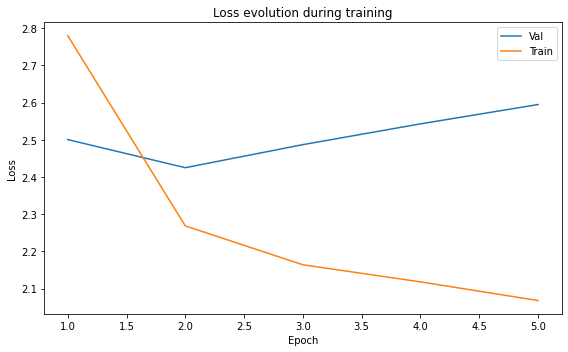

In [214]:
plot_curves(curves)

In [215]:
best_model_oxford = GeM_ResNet(features, pool).to(device)
best_model_oxford.load_state_dict(torch.load("best_model.pt"), strict=False)

best_model_oxford.fc = torch.nn.Identity()
best_model_oxford.eval()

GeM_ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [216]:
db_features_oxford, querys_features_oxford = feature_extractor("roxford5k",best_model_oxford,transform_val,device=device)

Extrayendo Caracteristicas: 100%|██████████| 70/70 [00:00<00:00, 71.59it/s]


In [217]:
evaluate(db_features_oxford,querys_features_oxford, data_roxford5k,"roxford5k")

>> roxford5k: mAP E: 47.49, M: 43.94, H: 32.31


In [218]:
np.savez('features_oxford.npz', bbdd=db_features_oxford, querys=querys_features_oxford)

## Entrenamiento Paris

In [195]:
EPOCH = 5
BATCH_SIZE = 16
LR = 1e-2
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_gem_paris = GeM_ResNet(features, pool).to(device)

optimizer = torch.optim.SGD(model_gem_paris.parameters(), lr=LR, momentum=0.9)

curves= train_model(
        model= model_gem_paris,
        train_dataset=paris_dataset_train,
        val_dataset=paris_dataset_val,
        max_epochs=EPOCH,
        batch_size=BATCH_SIZE,
        lr=LR,
        optimizador= optimizer,
        criterion = criterion,
        early_stopping_tolerance=5,
        save_best_model=True,
        device = device
    )

Epoch 1/5 - Batch 539/539
 - Train loss: 4.16635, Val loss: 4.11486
Epoch 2/5 - Batch 539/539
 - Train loss: 3.80358, Val loss: 2.60075
Epoch 3/5 - Batch 539/539
 - Train loss: 2.30762, Val loss: 2.24839
Epoch 4/5 - Batch 539/539
 - Train loss: 2.11012, Val loss: 2.09701
Epoch 5/5 - Batch 539/539
 - Train loss: 2.03766, Val loss: 2.11067

Tiempo total de entrenamiento: 2897.8999 [s]


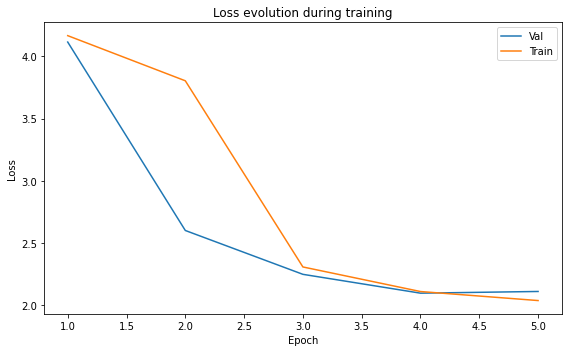

In [196]:
plot_curves(curves)

In [197]:
best_model_paris = GeM_ResNet(features, pool).to(device)
best_model_paris.load_state_dict(torch.load("best_model.pt"), strict=False)

best_model_paris.fc = torch.nn.Identity()
best_model_paris.eval()

GeM_ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [ ]:
db_features_paris, querys_features_paris = feature_extractor("rparis6k",best_model_paris,transform_val,device=device)

In [199]:
evaluate(db_features_paris,querys_features_paris, data_rparis6k,"rparis6k")

>> rparis6k: mAP E: 90.47, M: 90.98, H: 84.53


In [200]:
np.savez('features_paris.npz', bbdd=db_features_paris, querys=querys_features_paris)

## Prueba cruzando modelos

In [ ]:
#Modelo de Paris en dataset Oxford
db_features_oxford, querys_features_oxford = feature_extractor("roxford5k",best_model_paris,transform_val,device=device)

In [204]:
evaluate(db_features_oxford,querys_features_oxford, data_roxford5k,"roxford5k")

>> roxford5k: mAP E: 31.9, M: 26.94, H: 12.75


In [205]:
np.savez('features_oxford2.npz', bbdd=db_features_oxford, querys=querys_features_oxford)

In [219]:
#Modelo de Oxford en dataset Paris
db_features_paris, querys_features_paris = feature_extractor("rparis6k",best_model_oxford,transform_val,device=device)

Extrayendo Caracteristicas: 100%|██████████| 70/70 [00:01<00:00, 64.17it/s]


In [220]:
evaluate(db_features_paris,querys_features_paris, data_rparis6k, "rparis6k")

>> rparis6k: mAP E: 89.22, M: 86.46, H: 74.77


In [221]:
np.savez('features_paris2.npz', bbdd=db_features_paris, querys=querys_features_paris)

## Visualizacion mejor/peor AP

Vamos a escoger el modelo que se entreno con el dataset de Oxford debido a que se obtienen mejores resultados en promedio que el modelo que se entreno con el dataset de Paris.

In [222]:
oxford_features = np.load('features_oxford.npz')

db_features_oxford = oxford_features['bbdd']
querys_features_oxford = oxford_features['querys']

In [223]:
paris_features = np.load('features_paris2.npz')

db_features_paris = paris_features['bbdd']
querys_features_paris = paris_features['querys']

In [224]:
#==========OXFORD==========#
cosine_sim = cosine_similarity(db_features_oxford, querys_features_oxford)
ranks = np.argsort(cosine_sim, axis=0)[::-1]

aps_easy = get_ap(db_features_oxford, querys_features_oxford, data_roxford5k, dificultad="easy")
aps_medium= get_ap(db_features_oxford, querys_features_oxford, data_roxford5k, dificultad="medium")
aps_hard= get_ap(db_features_oxford, querys_features_oxford, data_roxford5k, dificultad="hard")

Mejor pos:25 AP: 1.0


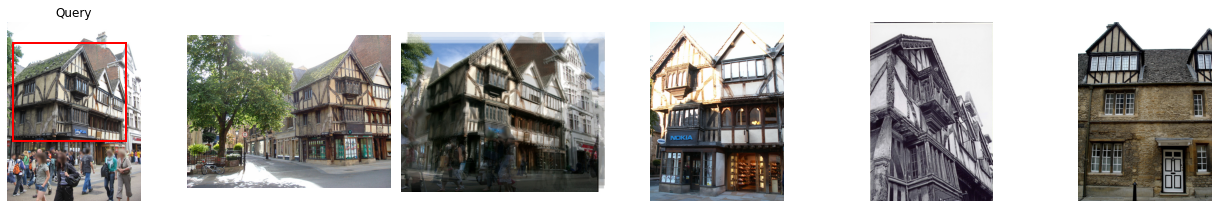

Peor pos:11 AP: 0.0


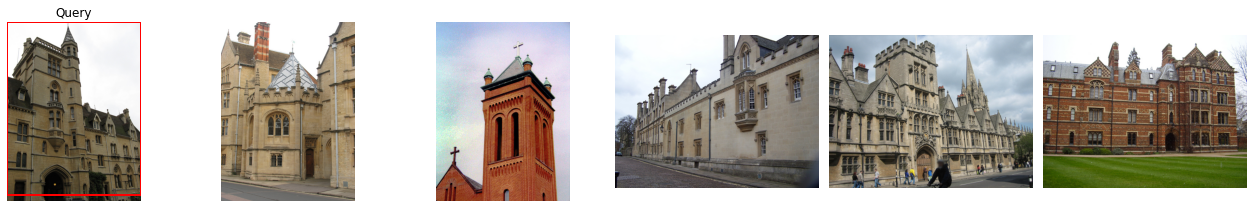

In [225]:
plot_mejor_peor(aps_easy, data_roxford5k, ranks, dataset_name = "roxford5k")

Mejor pos:54 AP: 0.9717871164112978


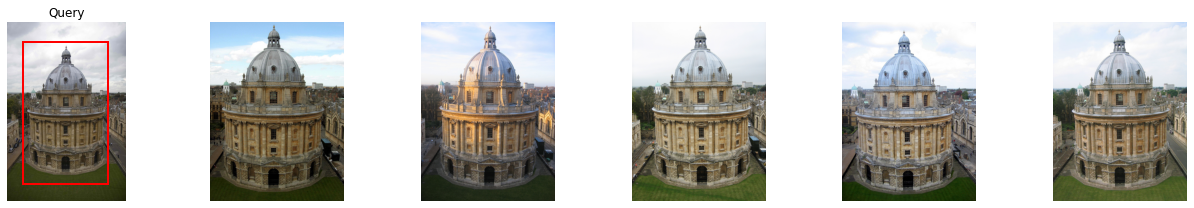

Peor pos:39 AP: 0.0003187317060034106


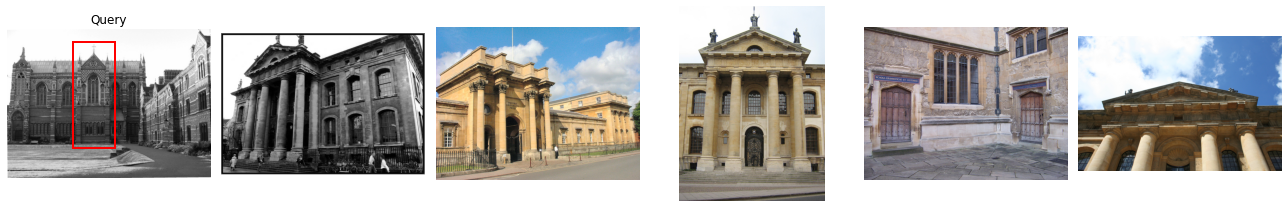

In [226]:
plot_mejor_peor(aps_medium, data_roxford5k, ranks, dataset_name = "roxford5k")

Mejor pos:62 AP: 0.4589745030828293


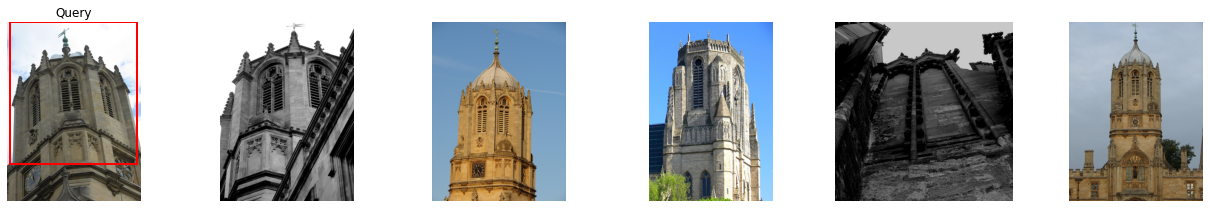

Peor pos:39 AP: 0.0001438021282714984


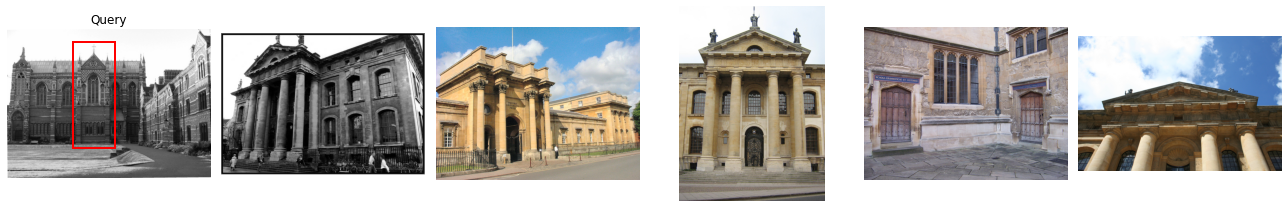

In [227]:
plot_mejor_peor(aps_hard, data_roxford5k, ranks, dataset_name = "roxford5k")

In [228]:
#==========PARIS==========#
cosine_sim = cosine_similarity(db_features_paris, querys_features_paris)
ranks = np.argsort(cosine_sim, axis=0)[::-1]

aps_easy = get_ap(db_features_paris, querys_features_paris, data_rparis6k, dificultad="easy")
aps_medium= get_ap(db_features_paris, querys_features_paris, data_rparis6k, dificultad="medium")
aps_hard= get_ap(db_features_paris, querys_features_paris, data_rparis6k, dificultad="hard")

Mejor pos:10 AP: 0.9267853266730208


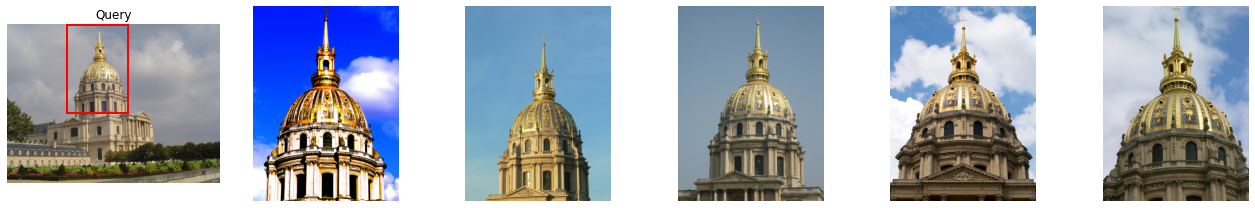

Peor pos:69 AP: 0.006821249708172947


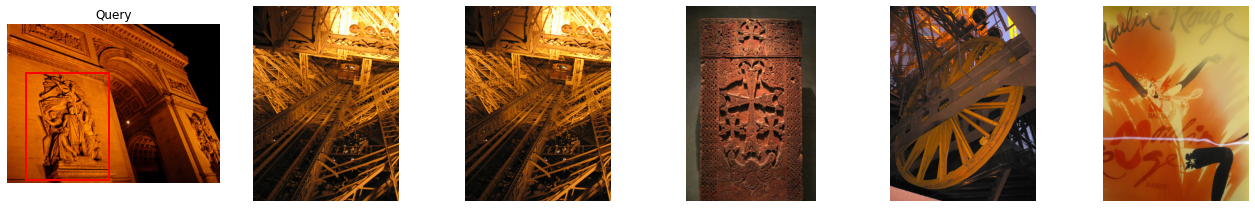

In [229]:
plot_mejor_peor(aps_easy, data_rparis6k, ranks, dataset_name = "rparis6k")

Mejor pos:20 AP: 0.9833747973111264


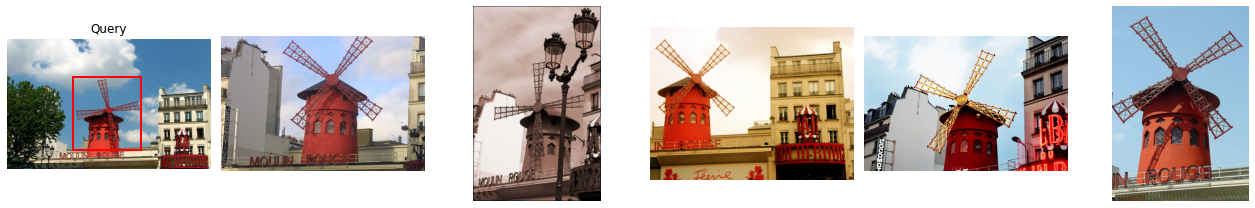

Peor pos:69 AP: 0.050652815689148506


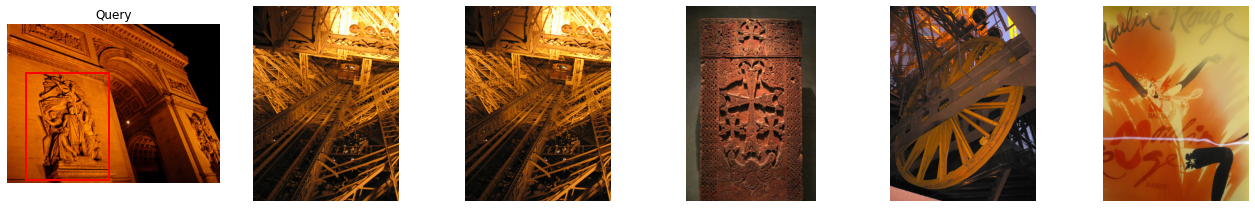

In [230]:
plot_mejor_peor(aps_medium, data_rparis6k, ranks, dataset_name = "rparis6k")

Mejor pos:65 AP: 0.7891034430456838


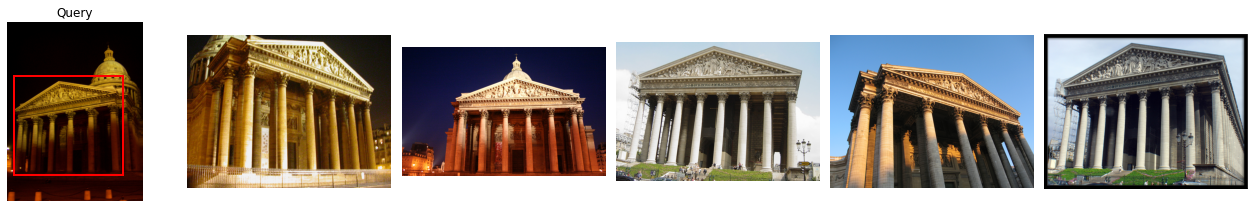

Peor pos:63 AP: 0.04357576753419025


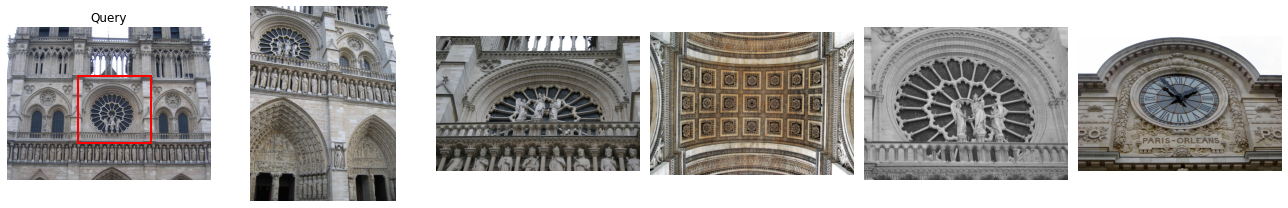

In [231]:
plot_mejor_peor(aps_hard, data_rparis6k, ranks, dataset_name = "rparis6k")